In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Tue Aug  2 15:51:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 73%   83C    P2   163W / 260W |   5339MiB / 11019MiB |     94%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 32%   

# MongoDB

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2019 = db.rm_patent_cn_2019
    db_rm_us_2019 = db.rm_patent_us_2019
    db_rm_de_2019 = db.rm_patent_de_2019

    
except errors.ConnectionFailure as err:
    print(err)

# 2019

## Company數量

In [6]:
data_assignee = db_rm_de_2019.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [7]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
data_assignee = db_rm_cn_2019.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_us_2019.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
# final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

### DE

In [11]:
# 取總數前15家公司
df_family_de.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
11,Intel Corp,18
19,Samsung Electronics Co Ltd,18
14,LG Electronics Inc,11
25,Sony Corp,10
20,Siemens AG,9
4,Fraunhofer Gesellschaft zur Forderung der Ange...,8
15,NEC Corp,7
26,Sony Group Corp,7
27,Sony Semiconductor Solutions Corp,6
21,Siemens Energy Global GmbH and Co KG,6


In [12]:
com_de_df = df_family_de.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_de_df.reset_index(drop=True, inplace=True)

In [13]:
com_de_df["count_log"] = com_de_df["count"].apply(lambda x: np.log(x))
com_de_df

,company,count,count_log
0,Intel Corp,18,2.890372
1,Samsung Electronics Co Ltd,18,2.890372
2,LG Electronics Inc,11,2.397895
3,Sony Corp,10,2.302585
4,Siemens AG,9,2.197225
5,Fraunhofer Gesellschaft zur Forderung der Ange...,8,2.079442
6,NEC Corp,7,1.945910
7,Sony Group Corp,7,1.945910
8,Sony Semiconductor Solutions Corp,6,1.791759
9,Siemens Energy Global GmbH and Co KG,6,1.791759


In [14]:
com_de_ls = list(com_de_df.company)

### CN

In [15]:
# 取總數前15家公司
df_family_cn.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
14,Huawei Technologies Co Ltd,411
21,Shanghai Langbo Communication Technology Co Ltd,135
17,NTT Docomo Inc,133
8,China Mobile Communications Group Co Ltd,124
20,Samsung Electronics Co Ltd,117
13,Guangdong Oppo Mobile Telecommunications Corp Ltd,104
10,China Mobile IoT Co Ltd,77
18,Neusoft Corp,70
27,Telefonaktiebolaget LM Ericsson AB,65
0,Alibaba Group Holding Ltd,62


In [16]:
com_cn_df = df_family_cn.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_cn_df.reset_index(drop=True, inplace=True)

In [17]:
com_cn_df["count_log"] = com_cn_df["count"].apply(lambda x: np.log(x))
com_cn_df

,company,count,count_log
0,Huawei Technologies Co Ltd,411,6.018593
1,Shanghai Langbo Communication Technology Co Ltd,135,4.905275
2,NTT Docomo Inc,133,4.890349
3,China Mobile Communications Group Co Ltd,124,4.820282
4,Samsung Electronics Co Ltd,117,4.762174
5,Guangdong Oppo Mobile Telecommunications Corp Ltd,104,4.644391
6,China Mobile IoT Co Ltd,77,4.343805
7,Neusoft Corp,70,4.248495
8,Telefonaktiebolaget LM Ericsson AB,65,4.174387
9,Alibaba Group Holding Ltd,62,4.127134


In [18]:
com_cn_ls = list(com_cn_df.company)

### US

In [19]:
# 取總數前15家公司
df_family_us.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
22,Qualcomm Inc,1194
14,LG Electronics Inc,725
23,Samsung Electronics Co Ltd,675
12,International Business Machines Corp,575
27,Telefonaktiebolaget LM Ericsson AB,403
11,Intel Corp,273
4,Cisco Technology Inc,261
18,Microsoft Technology Licensing LLC,218
2,Apple Inc,183
0,AT&T Intellectual Property I LP,183


In [20]:
com_us_df = df_family_us.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_us_df.reset_index(drop=True, inplace=True)

In [21]:
com_us_df["count_log"] = com_us_df["count"].apply(lambda x: np.log(x))
com_us_df

,company,count,count_log
0,Qualcomm Inc,1194,7.085064
1,LG Electronics Inc,725,6.586172
2,Samsung Electronics Co Ltd,675,6.514713
3,International Business Machines Corp,575,6.354370
4,Telefonaktiebolaget LM Ericsson AB,403,5.998937
5,Intel Corp,273,5.609472
6,Cisco Technology Inc,261,5.564520
7,Microsoft Technology Licensing LLC,218,5.384495
8,Apple Inc,183,5.209486
9,AT&T Intellectual Property I LP,183,5.209486


In [22]:
com_us_ls = list(com_us_df.company)

# Data

## CN

In [23]:
ccontry = pd.read_csv("../rm_company_country_cn_2019.csv")
ccpc = pd.read_csv("../rm_company_cpc_cn_2019.csv")

In [24]:
ccontry[ccontry.company.isin(com_cn_ls)]

,company,AR,AU,BE,BR,CA,CL,CN,CO,DE,...,MX,NL,PH,PL,RU,SE,SG,TW,US,ZA
34,Alibaba Group Holding Ltd,0.0,0.0,0.0,0.0,0.0,0.0,62.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0
109,Apple Inc,0.0,1.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
486,China Mobile Communications Group Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,249.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,China Mobile IoT Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,156.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
520,China United Network Communications Group Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
908,Guangdong Oppo Mobile Telecommunications Corp Ltd,0.0,29.0,0.0,5.0,15.0,0.0,103.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,14.0,6.0,55.0,0.0
1302,Huawei Technologies Co Ltd,0.0,5.0,0.0,1.0,7.0,0.0,411.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0
1759,NTT Docomo Inc,0.0,13.0,0.0,6.0,15.0,0.0,137.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,8.0,0.0
1892,Neusoft Corp,0.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2169,Samsung Electronics Co Ltd,0.0,1.0,0.0,0.0,1.0,0.0,147.0,0.0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,4.0,2.0,92.0,0.0


### Similarity計算

#### Country

- 換成機率  

In [25]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

#### PBC
- 和Samsung Electronics Co Ltd比較

In [26]:
ccontry_pbc = ccontry2.loc[com_cn_ls,:].copy()
ccontry_pbc.head()

,AR,AU,BE,BR,CA,CL,CN,CO,DE,DK,...,MX,NL,PH,PL,RU,SE,SG,TW,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Huawei Technologies Co Ltd,0.0,0.009615,0.0,0.001923,0.013462,0.0,0.790385,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.063462,0.0
Shanghai Langbo Communication Technology Co Ltd,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.905405,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.094595,0.0
NTT Docomo Inc,0.0,0.040248,0.0,0.018576,0.046440,0.0,0.424149,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.006192,0.006192,0.024768,0.0
China Mobile Communications Group Co Ltd,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0
Samsung Electronics Co Ltd,0.0,0.002212,0.0,0.000000,0.002212,0.0,0.325221,0.0,0.004425,0.0,...,0.0,0.0,0.0,0.0,0.002212,0.0,0.008850,0.004425,0.203540,0.0


In [27]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

#### CPC

In [28]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [29]:
ccpc_pbc = ccpc2.loc[com_cn_ls,:].copy()
# ccpc_pbc

In [30]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### Scatter Plot

In [31]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_cn_df.count_log[com_cn_df.company=="Samsung Electronics Co Ltd"].values-com_cn_df.count_log[com_cn_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_cn_df.count_log[com_cn_df.company=="Samsung Electronics Co Ltd"].values-com_cn_df.count_log[com_cn_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

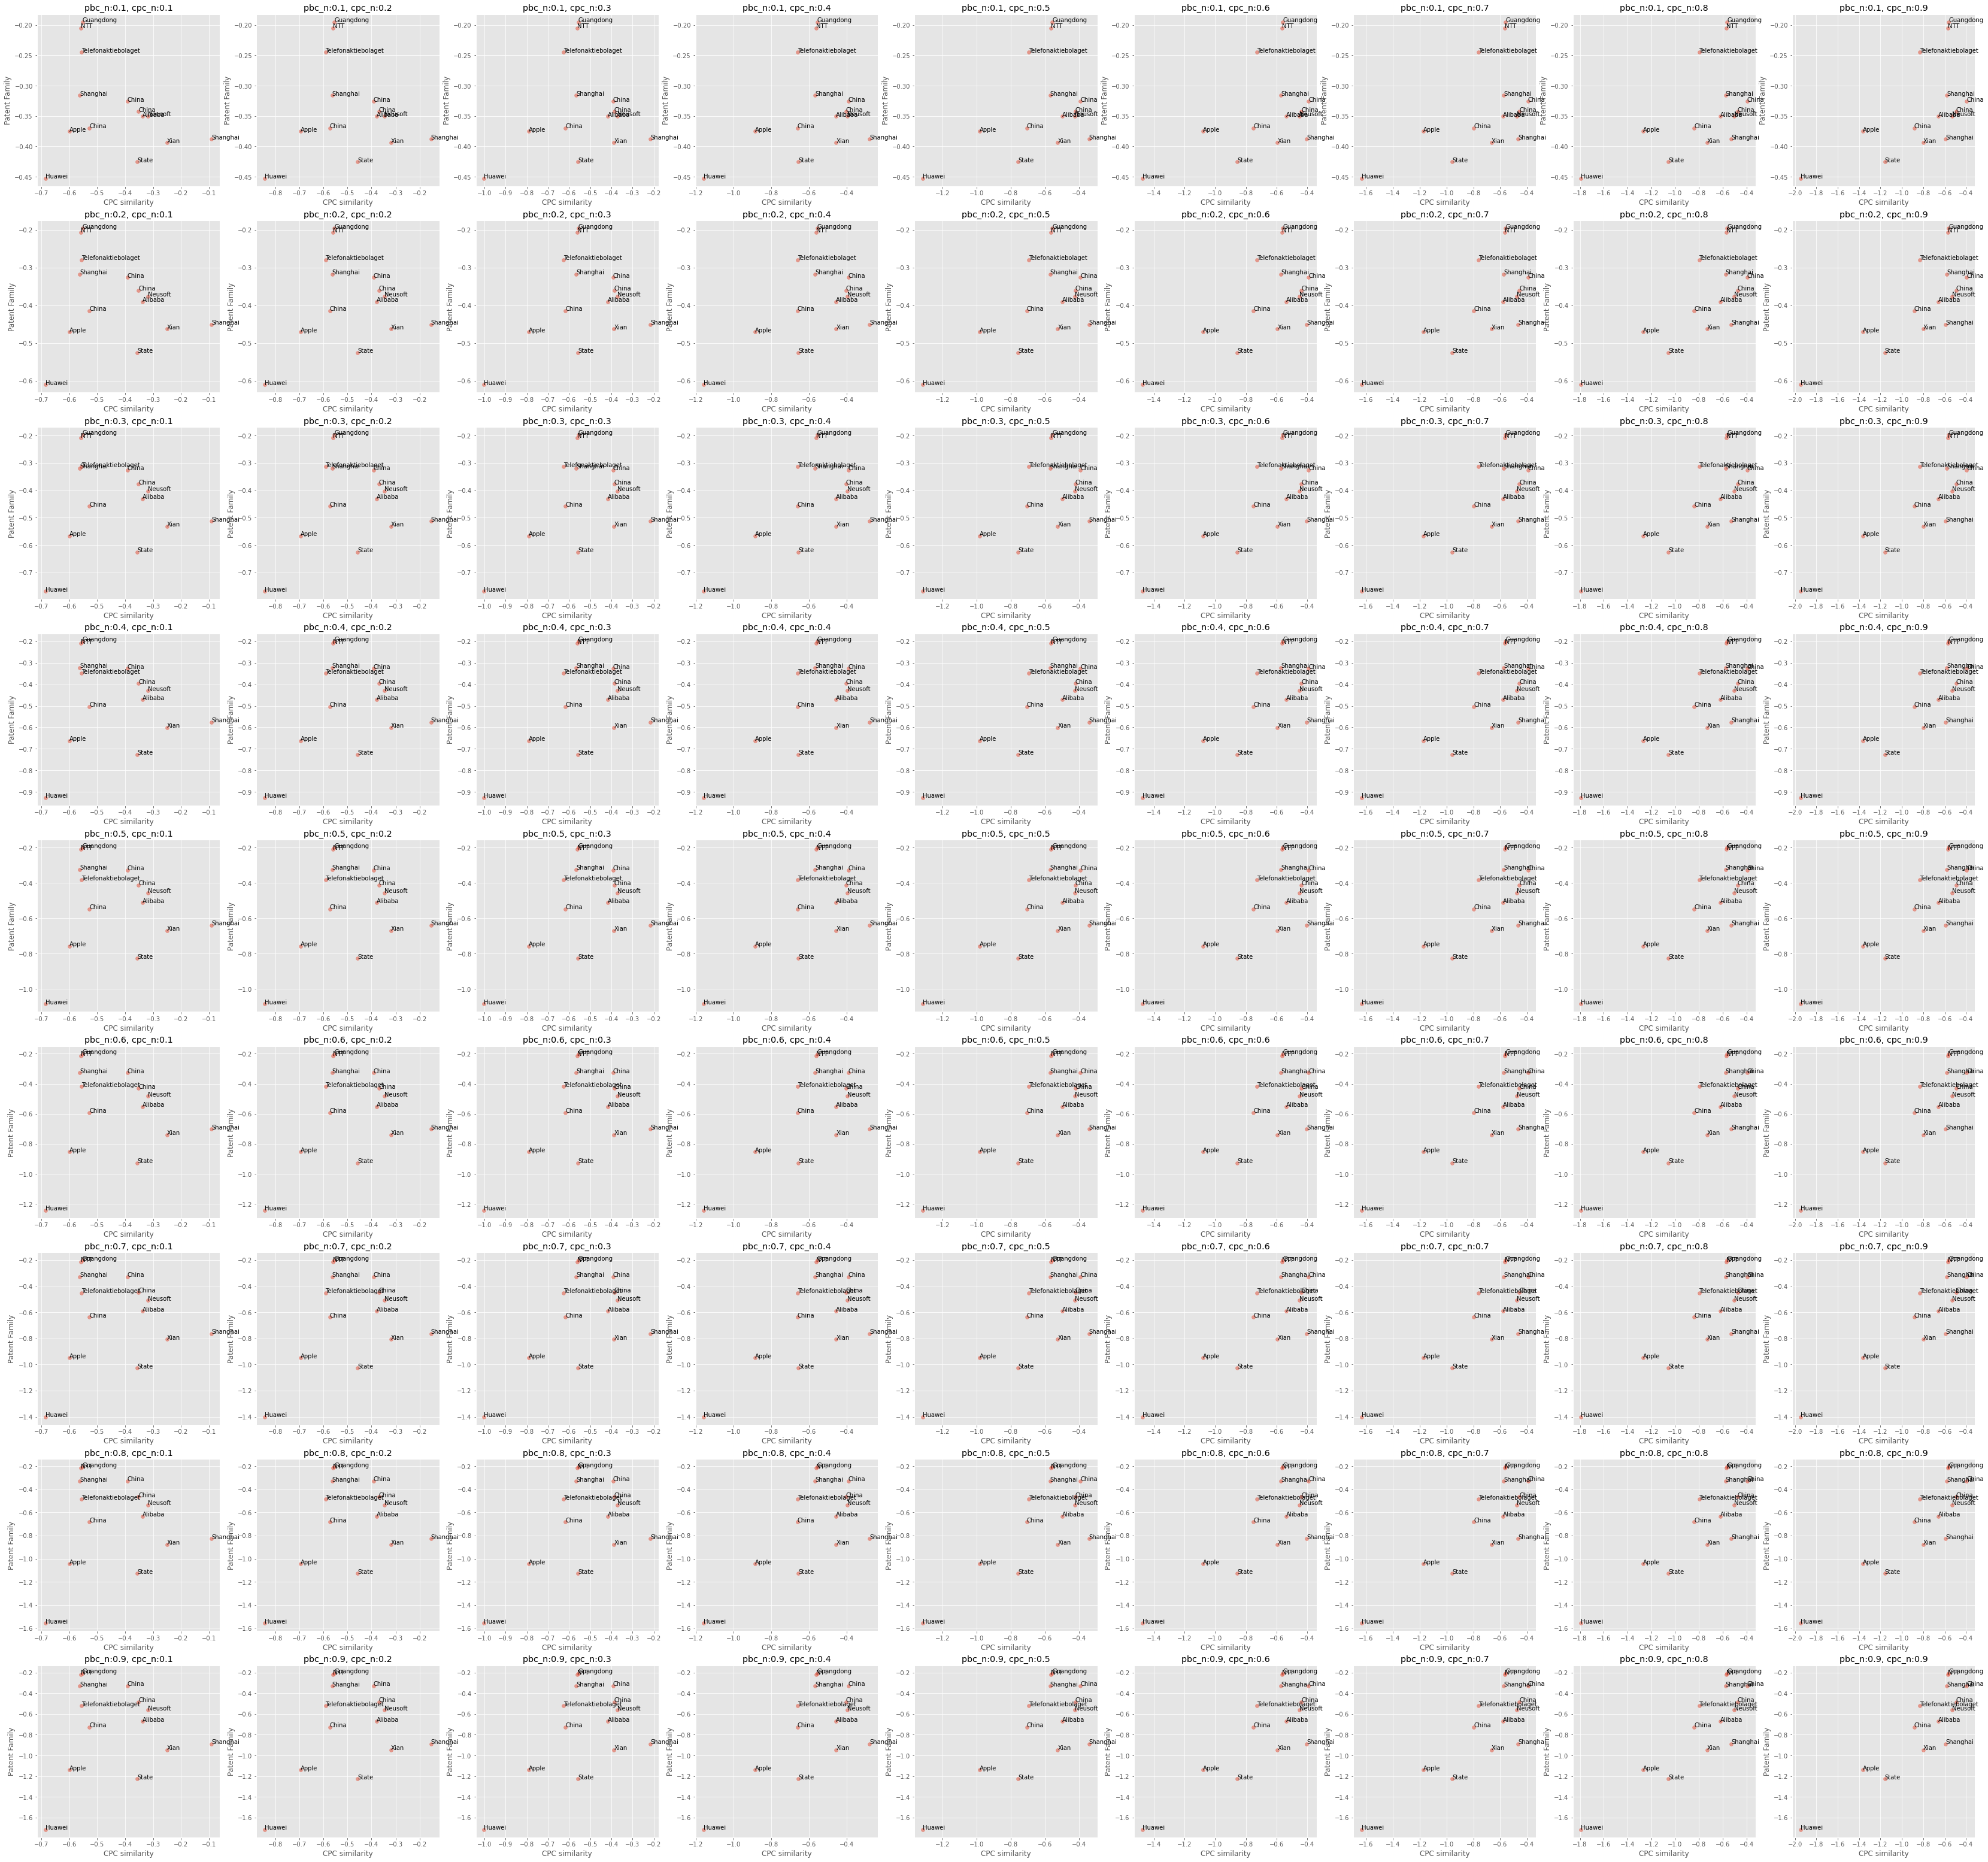

In [32]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_cn_2019_1.png'.format(pbc_n))

In [33]:
c_df

,cpc,country
company,,
Huawei Technologies Co Ltd,1.948319,1.715621
Shanghai Langbo Communication Technology Co Ltd,0.578027,0.332141
NTT Docomo Inc,0.570429,0.217970
China Mobile Communications Group Co Ltd,0.394095,0.328260
Guangdong Oppo Mobile Telecommunications Corp Ltd,0.563890,0.206070
China Mobile IoT Co Ltd,0.491752,0.482750
Neusoft Corp,0.529787,0.561160
Telefonaktiebolaget LM Ericsson AB,0.832777,0.521241
Alibaba Group Holding Ltd,0.660205,0.672939


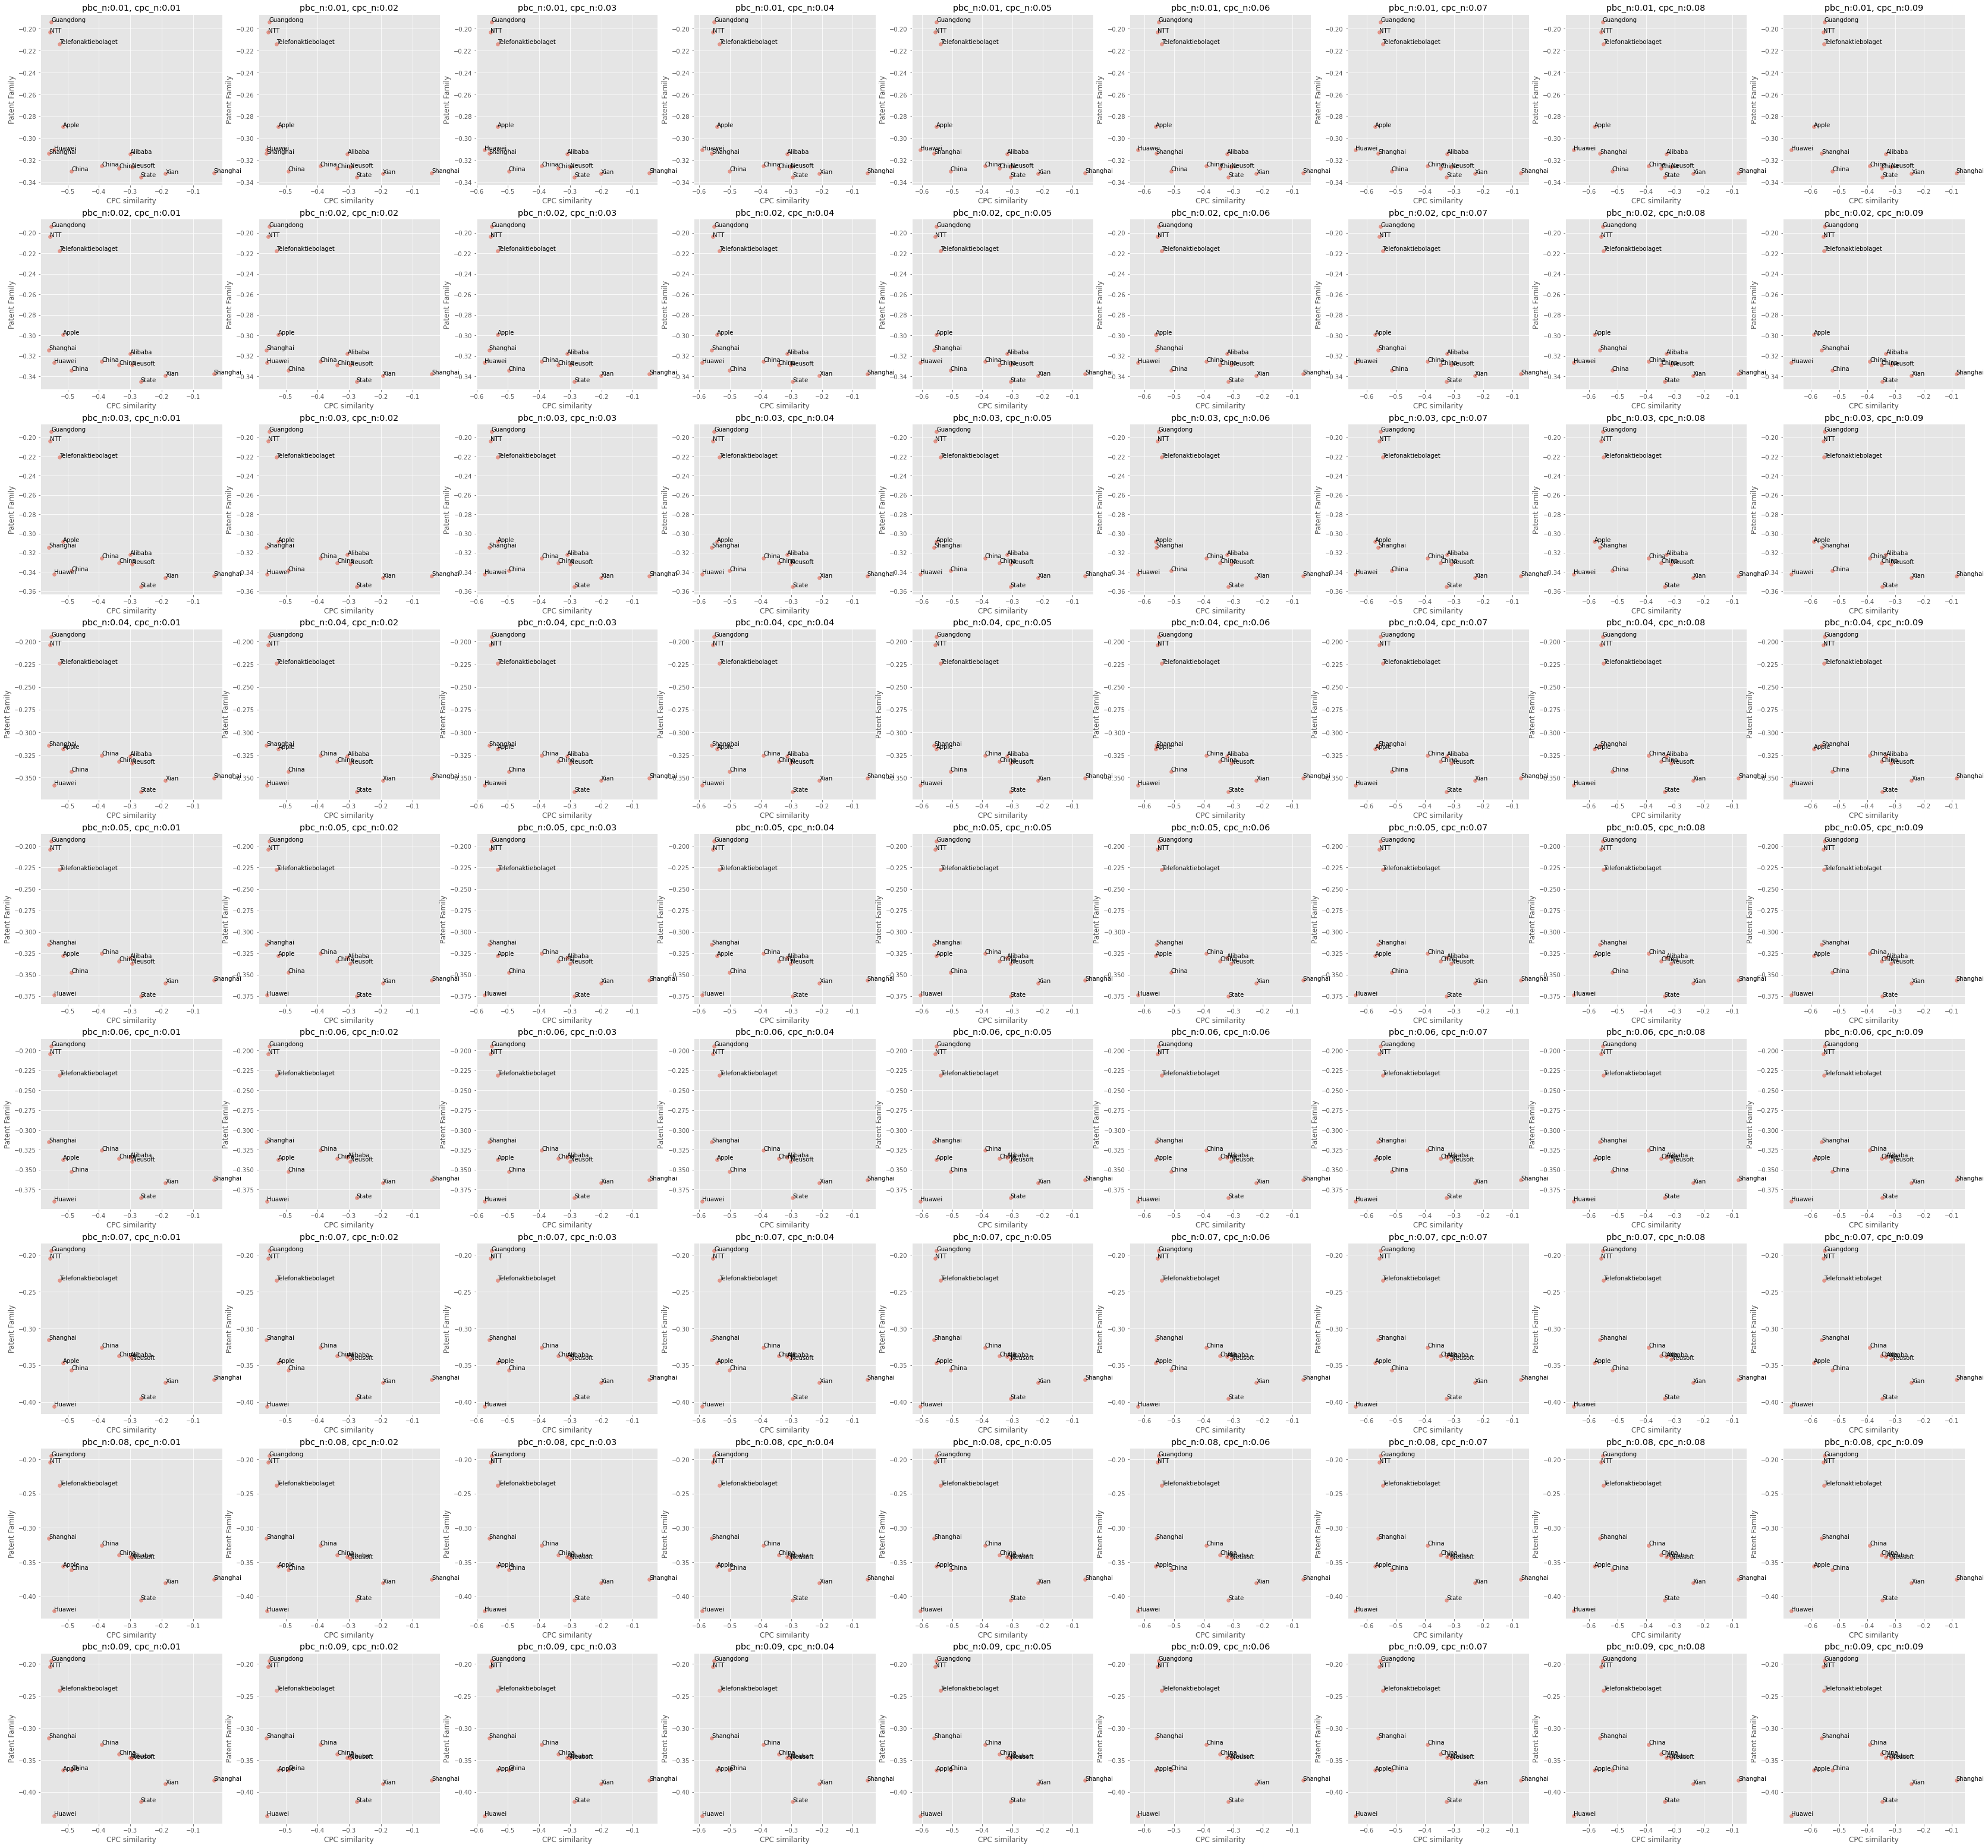

In [34]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_cn_2019_2.png'.format(pbc_n))

In [35]:
c_df

,cpc,country
company,,
Huawei Technologies Co Ltd,0.669662,0.436963
Shanghai Langbo Communication Technology Co Ltd,0.561440,0.315554
NTT Docomo Inc,0.557122,0.204662
China Mobile Communications Group Co Ltd,0.391360,0.325525
Guangdong Oppo Mobile Telecommunications Corp Ltd,0.552653,0.194833
China Mobile IoT Co Ltd,0.349976,0.340974
Neusoft Corp,0.316055,0.347429
Telefonaktiebolaget LM Ericsson AB,0.552928,0.241392
Alibaba Group Holding Ltd,0.333552,0.346286


### Scatter Plot2

In [36]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia")\
                                                    .replace("China Mobile IoT","China_Mobile_IoT")\
                                                    .replace("China Mobile","China_Mobile")\
                                                    .replace("China United Network Communications Group","China_Unicom")\
                                                    .replace("Shanghai Langbo Communication Technology","Shanghai_Langbo")\
                                                    .replace("State Grid of China SGCC","SGCC")\
                                                    .replace("Beijing Sankuai Online Technology","Beijing_Sankuai")\
                                                    .replace("Beijing Xiaomi Mobile Software","Xiaomi")\
                                                    .replace("Guangdong Oppo Mobile Telecommunications","Oppo")\
                                                    .replace("Shanghai Roye Electric Science and Technology","Shanghai_Roye_Electric")\
                                                    .replace("Xian Irain IoT Technology Servic","Xian_Irain"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

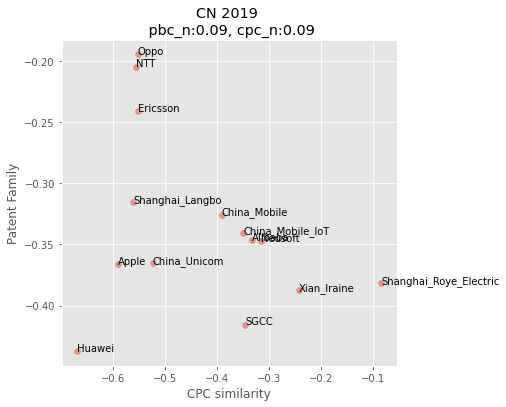

In [37]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("CN 2019 \n pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC similarity")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [38]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [39]:
competitor_ls

[4, 2, 2, 4, 2, 3, 3, 2, 3, 4, 3, 3, 4, 3]

In [40]:
c_df

,cpc,country
company,,
Huawei Technologies,0.669662,0.436963
Shanghai_Langbo,0.561440,0.315554
NTT Docomo,0.557122,0.204662
China_Mobile,0.391360,0.325525
Oppo,0.552653,0.194833
China_Mobile_IoT,0.349976,0.340974
Neusoft,0.316055,0.347429
Ericsson,0.552928,0.241392
Alibaba Group Holding,0.333552,0.346286


In [41]:
c_df.to_csv("competitor_df/company/cpc_cn_2019.csv")

## US

In [42]:
ccontry = pd.read_csv("../rm_company_country_us_2019.csv")
ccpc = pd.read_csv("../rm_company_cpc_us_2019.csv")

In [43]:
ccontry[ccontry.company.isin(com_us_ls)]

,company,AR,AT,AU,BE,BR,CA,CH,CL,CN,...,PT,RS,RU,SE,SG,TN,TR,TW,US,ZA
19,AT&T Intellectual Property I LP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.0,0.0
115,Apple Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,199.0,0.0
323,Cisco Technology Inc,0.0,0.0,4.0,0.0,0.0,7.0,0.0,0.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,260.0,0.0
671,Huawei Technologies Co Ltd,0.0,0.0,5.0,0.0,27.0,9.0,0.0,0.0,147.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0
741,Intel Corp,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,91.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,288.0,0.0
747,International Business Machines Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,578.0,1.0
862,LG Electronics Inc,1.0,0.0,7.0,0.0,5.0,2.0,0.0,3.0,95.0,...,0.0,0.0,5.0,0.0,4.0,0.0,0.0,3.0,721.0,0.0
981,Micron Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,165.0,0.0
982,Microsoft Technology Licensing LLC,0.0,0.0,4.0,0.0,1.0,4.0,0.0,1.0,55.0,...,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,217.0,1.0
1089,Nokia Technologies Oy,1.0,0.0,2.0,0.0,3.0,2.0,0.0,2.0,41.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,2.0,86.0,0.0


### Similarity計算

#### Country

- 換成機率  

In [44]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

#### PBC
- 和Samsung Electronics Co Ltd比較

In [45]:
ccontry_pbc = ccontry2.loc[com_us_ls,:].copy()
ccontry_pbc.head()

,AR,AT,AU,BE,BR,CA,CH,CL,CN,CO,...,PT,RS,RU,SE,SG,TN,TR,TW,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000256,0.0,0.022774,0.0,0.026612,0.004862,0.0,0.001024,0.227482,0.001535,...,0.000000,0.0,0.001024,0.0,0.044012,0.000256,0.000000,0.070880,0.301689,0.000512
LG Electronics Inc,0.000741,0.0,0.005189,0.0,0.003706,0.001483,0.0,0.002224,0.070423,0.000000,...,0.000000,0.0,0.003706,0.0,0.002965,0.000000,0.000000,0.002224,0.534470,0.000000
Samsung Electronics Co Ltd,0.000000,0.0,0.005658,0.0,0.000000,0.001886,0.0,0.000000,0.187647,0.000000,...,0.000000,0.0,0.001886,0.0,0.003300,0.000000,0.000000,0.009901,0.325318,0.000000
International Business Machines Corp,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.068254,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.917460,0.001587
Telefonaktiebolaget LM Ericsson AB,0.022176,0.0,0.013860,0.0,0.045045,0.015246,0.0,0.002772,0.143451,0.015939,...,0.005544,0.0,0.029799,0.0,0.002772,0.000000,0.000693,0.009009,0.278586,0.002772


In [46]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

#### CPC

In [47]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [48]:
ccpc_pbc = ccpc2.loc[com_us_ls,:].copy()
# ccpc_pbc

In [49]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### Scatter Plot

In [50]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_us_df.count_log[com_us_df.company=="Samsung Electronics Co Ltd"].values-com_us_df.count_log[com_us_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_us_df.count_log[com_us_df.company=="Samsung Electronics Co Ltd"].values-com_us_df.count_log[com_us_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

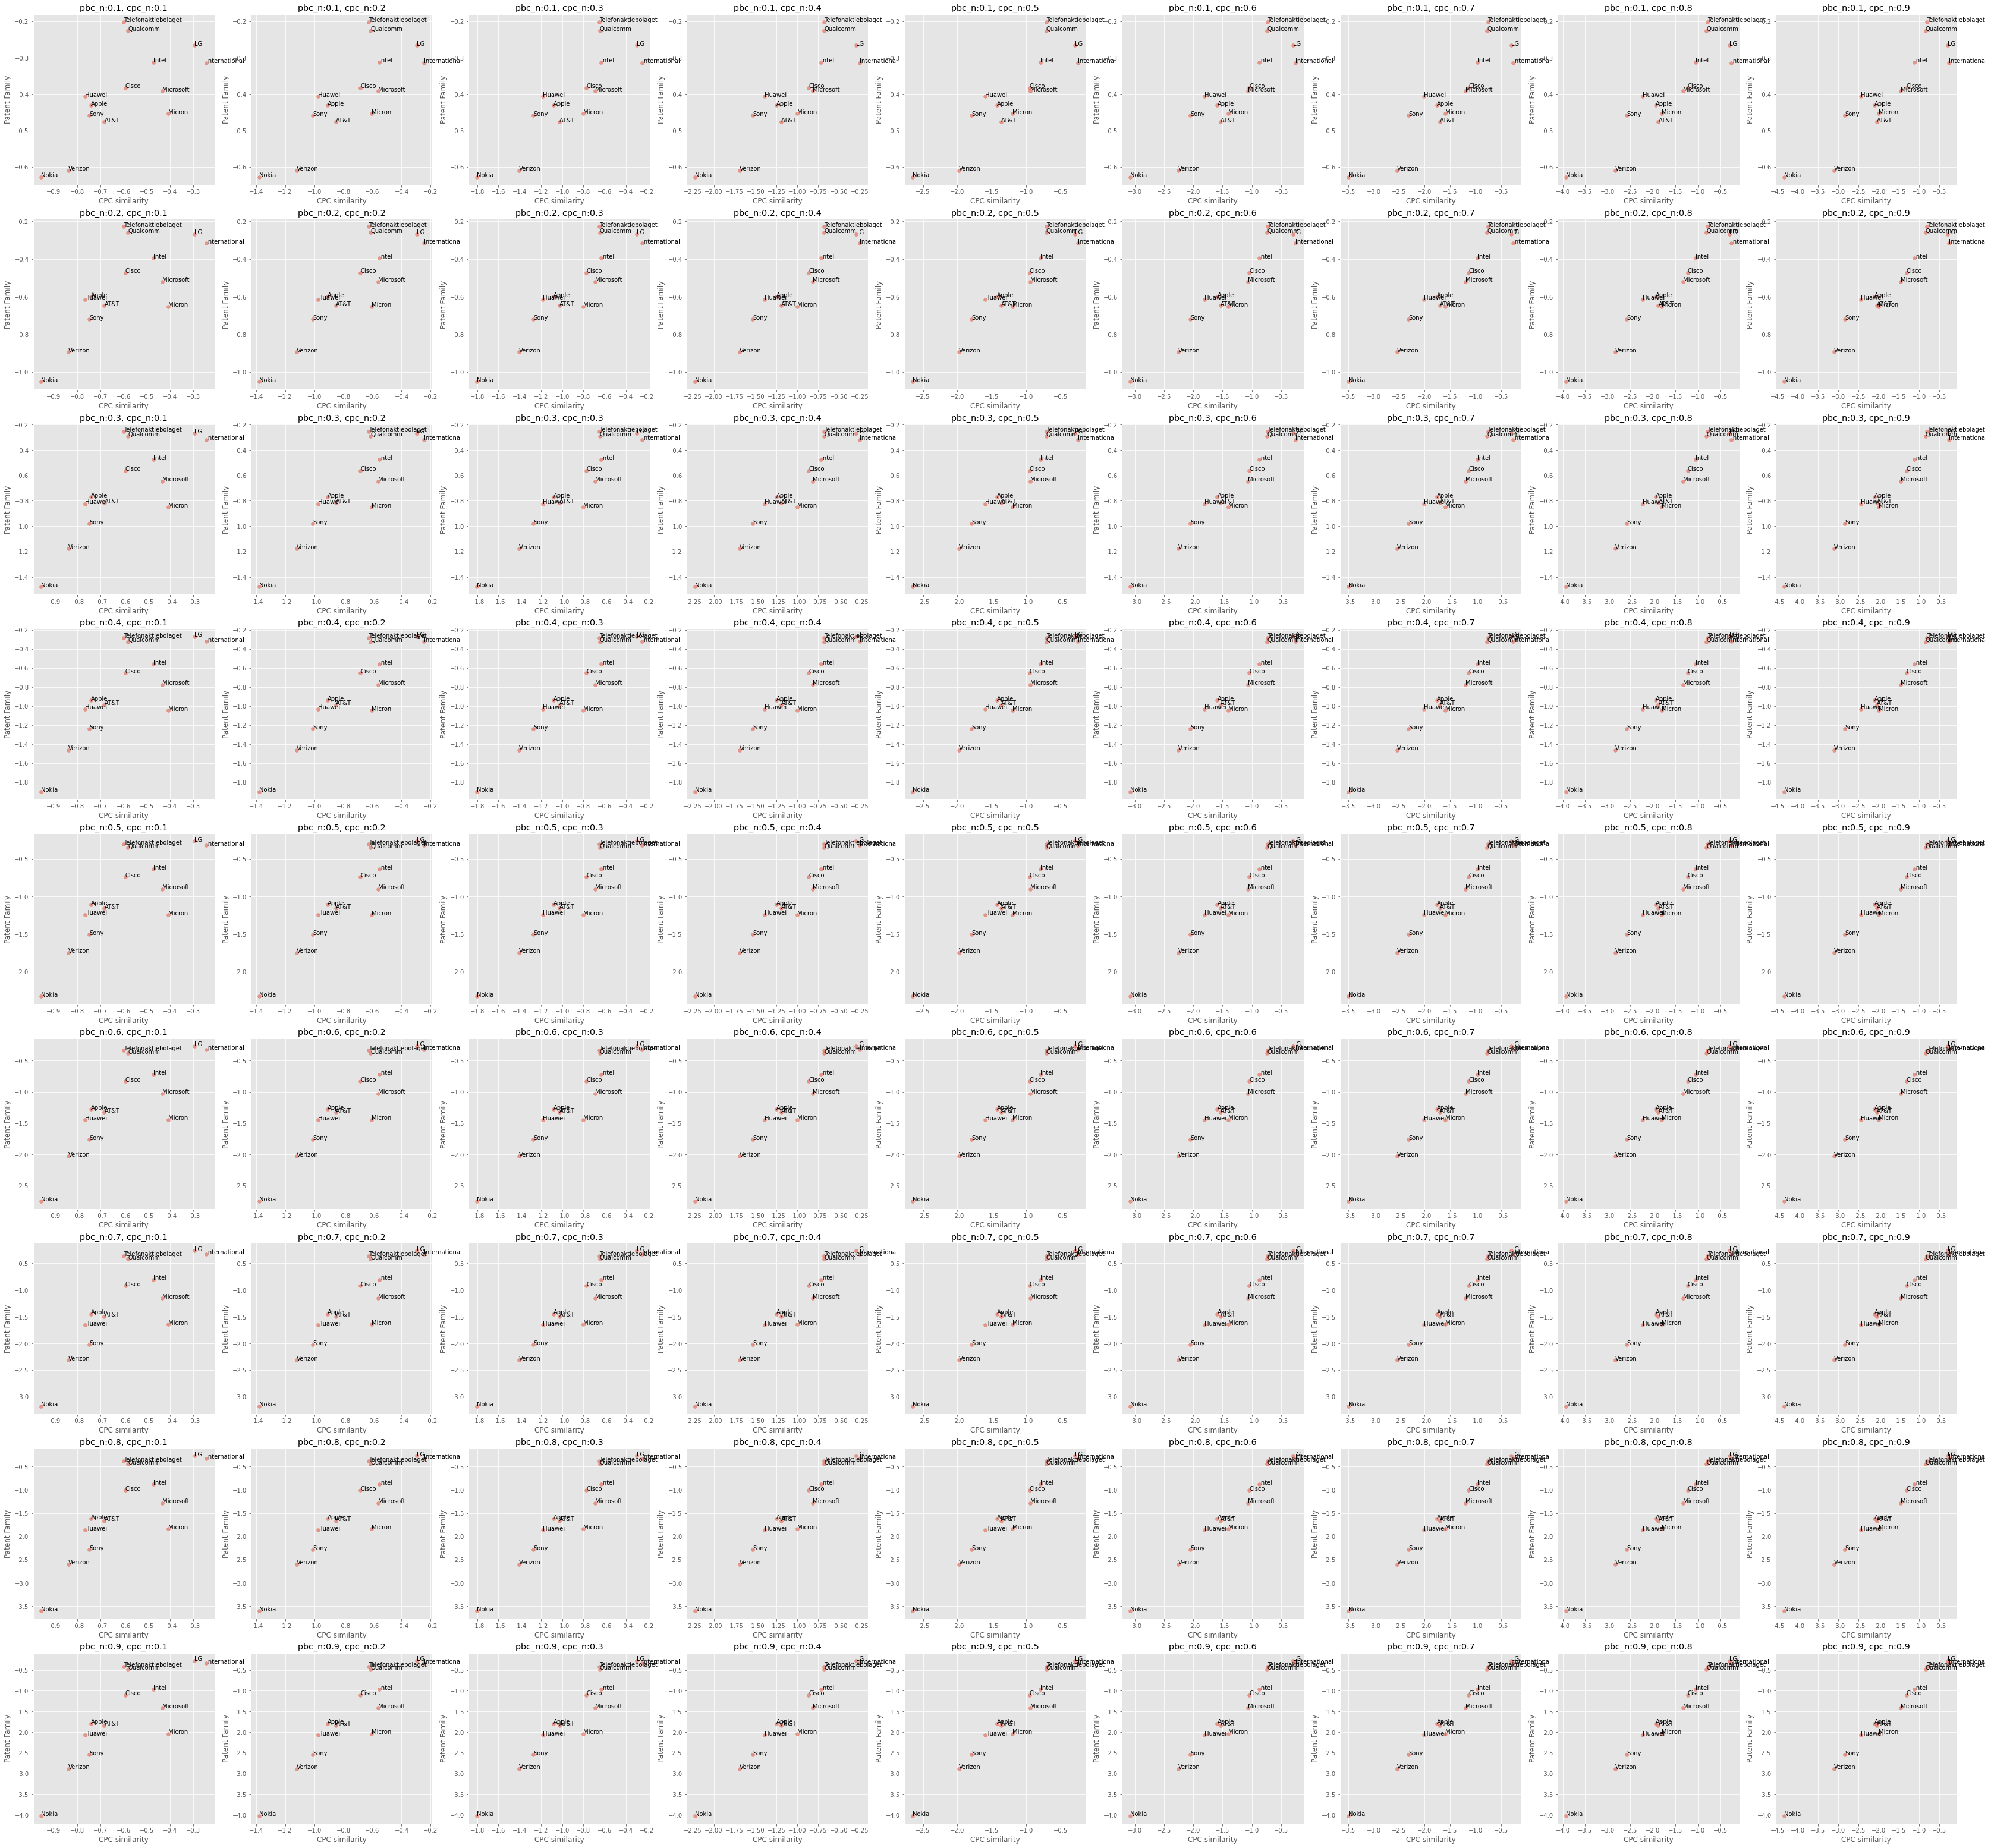

In [51]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_us_2019_1.png'.format(pbc_n))

In [52]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.840278,0.486303
LG Electronics Inc,0.298388,0.270194
International Business Machines Corp,0.263215,0.334482
Telefonaktiebolaget LM Ericsson AB,0.811262,0.414179
Intel Corp,1.125382,0.968180
Cisco Technology Inc,1.314120,1.104618
Microsoft Technology Licensing LLC,1.454936,1.413569
Apple Inc,2.102518,1.793430
AT&T Intellectual Property I LP,2.045234,1.839788


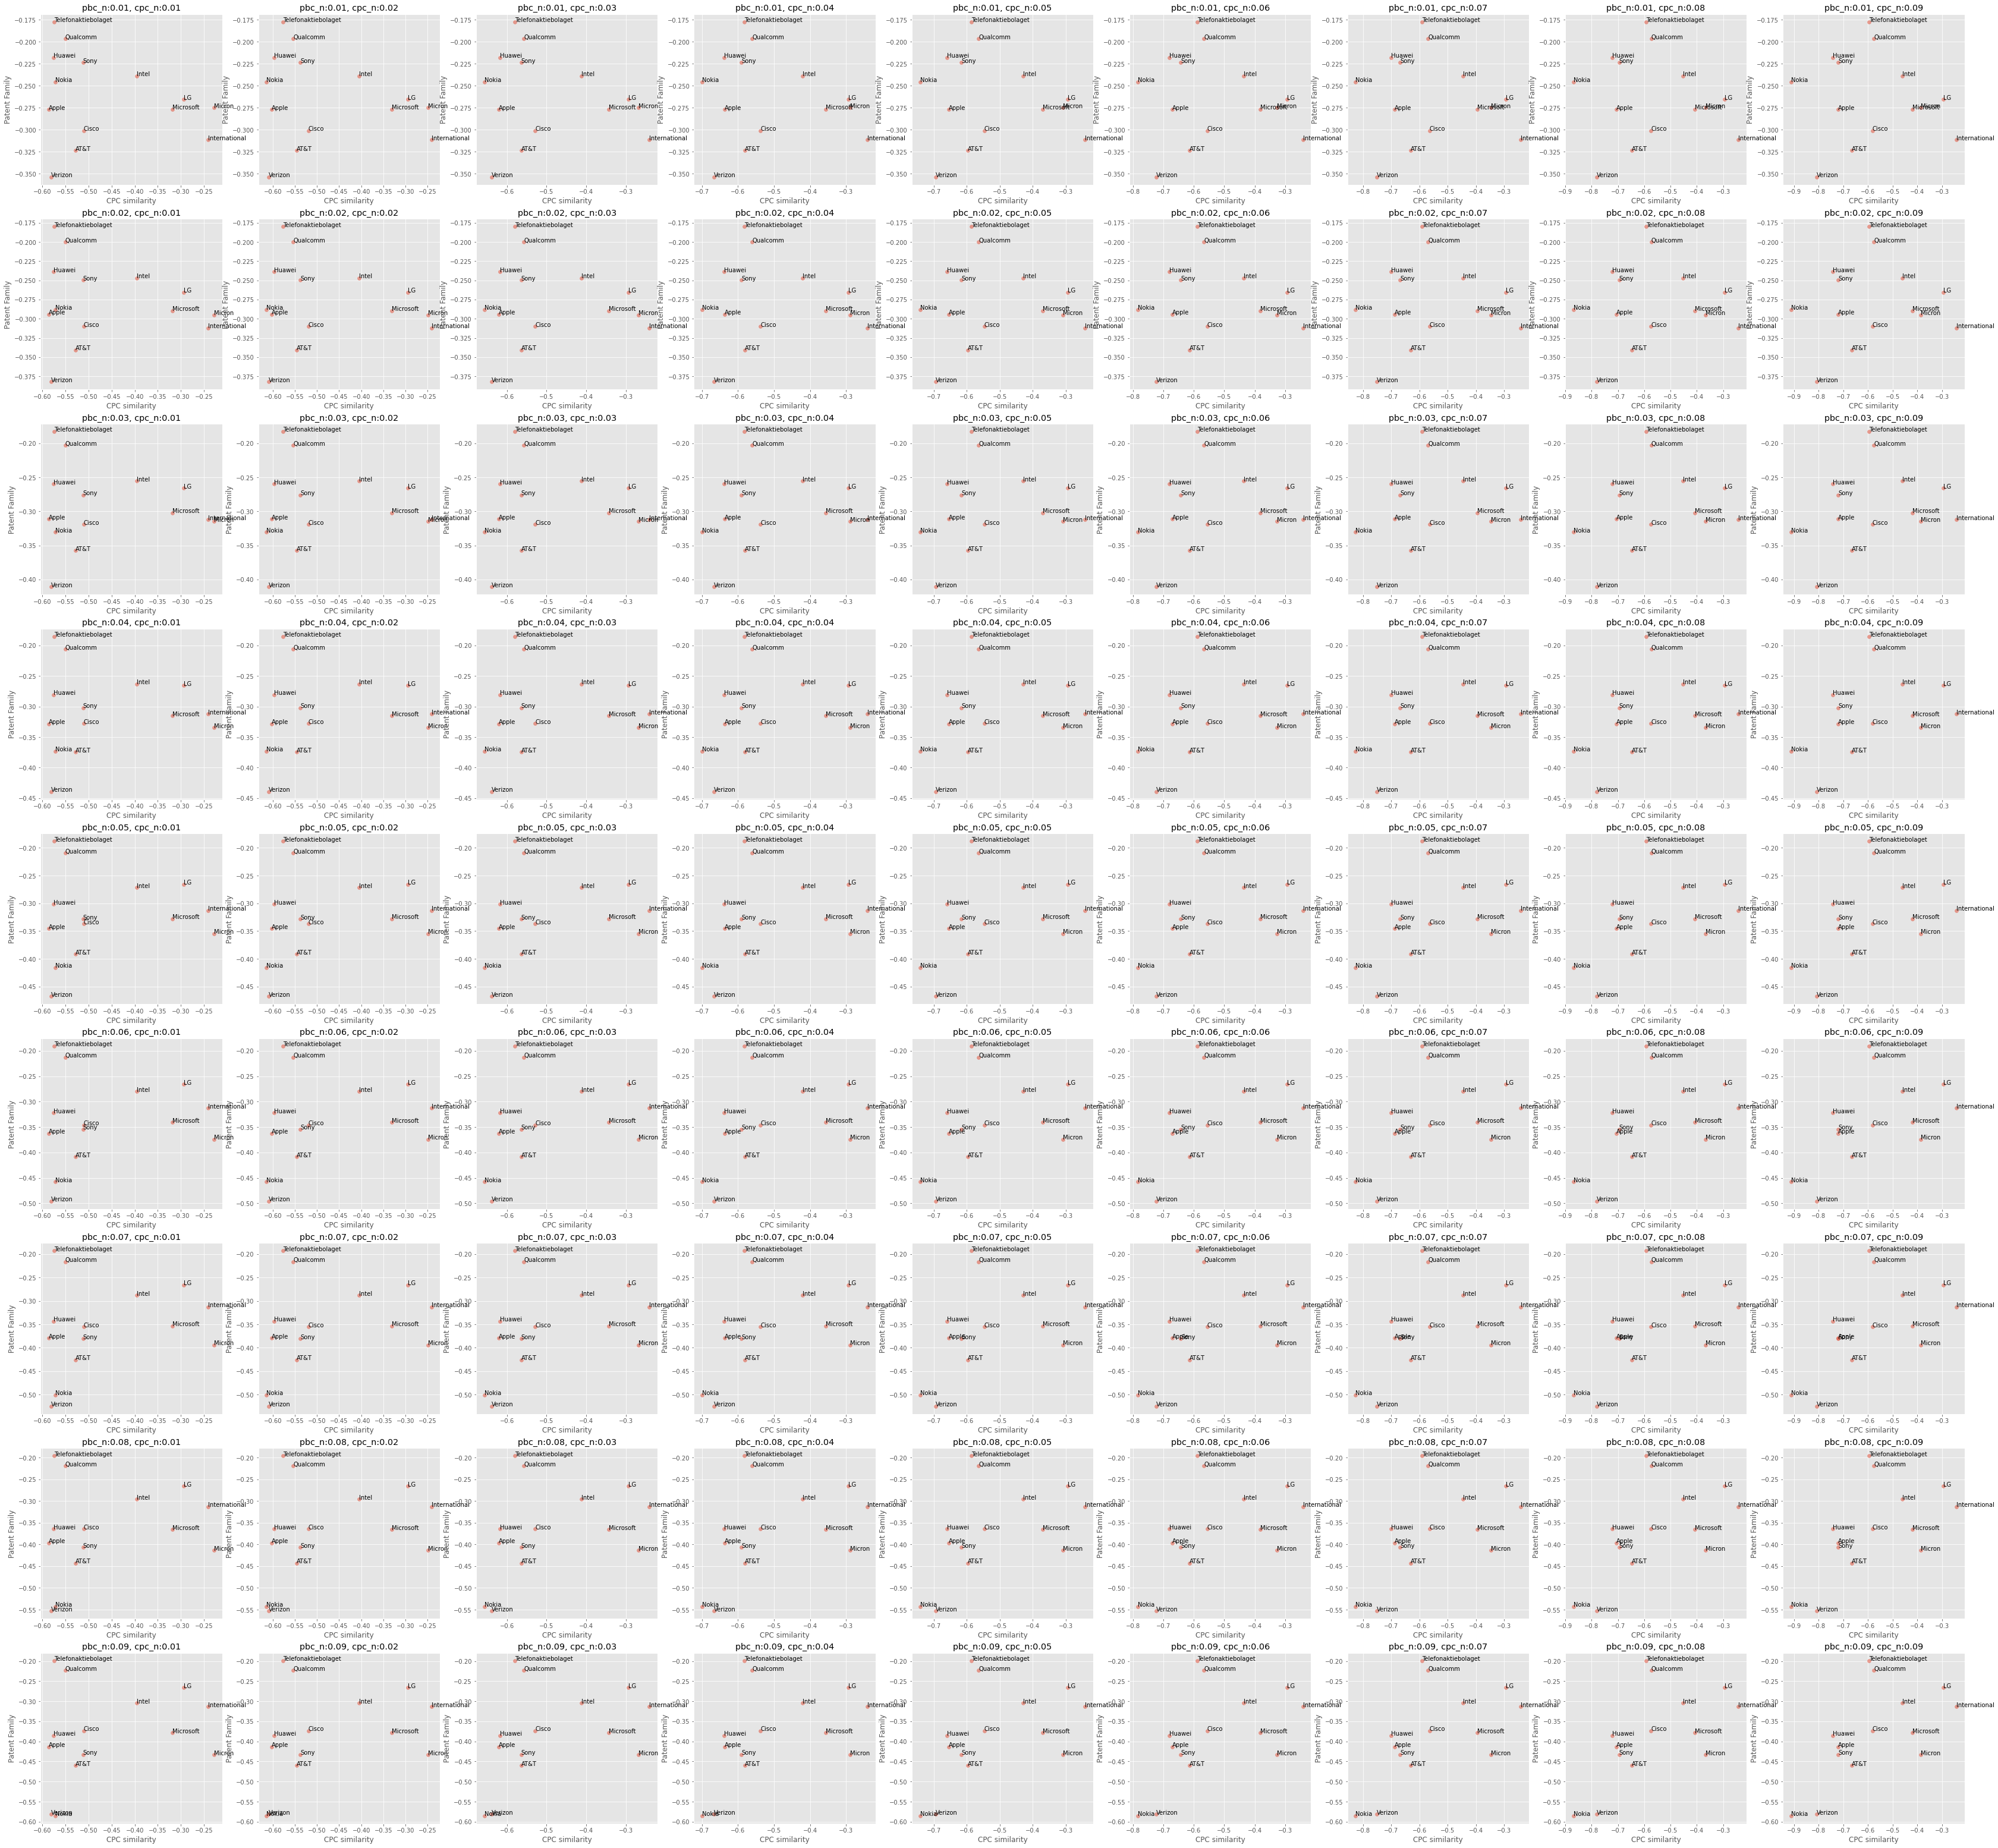

In [53]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_us_2019_2.png'.format(pbc_n))

In [54]:
c_df

,cpc,country
company,,
Qualcomm Inc,0.576785,0.222809
LG Electronics Inc,0.294252,0.266057
International Business Machines Corp,0.242390,0.313657
Telefonaktiebolaget LM Ericsson AB,0.595782,0.198698
Intel Corp,0.461619,0.304417
Cisco Technology Inc,0.582799,0.373297
Microsoft Technology Licensing LLC,0.420249,0.378882
Apple Inc,0.722589,0.413501
AT&T Intellectual Property I LP,0.665305,0.459859


### Scatter Plot2

In [55]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia")\
                                                    .replace("China Mobile","China_Mobile")\
                                                    .replace("China Mobile IoT","China_Mobile_IoT")\
                                                    .replace("China United Network Communications Group","China_Unicom")\
                                                    .replace("Shanghai Langbo Communication Technology","Shanghai_Langbo")\
                                                    .replace("State Grid of China SGCC","SGCC")\
                                                    .replace("Beijing Sankuai Online Technology","Beijing_Sankuai")\
                                                    .replace("Beijing Xiaomi Mobile Software","Xiaomi")\
                                                    .replace("Guangdong Oppo Mobile Telecommunications","Oppo")\
                                                    .replace("Shanghai Roye Electric Science and Technology","Shanghai_Roye_Electric")\
                                                    .replace("Xian Irain IoT Technology Servic","Xian_Irain")\
                                                    .replace("China University of Geosciences","CUG")\
                                                    .replace("Shenzhen Shenglu IoT Communication Technology","Shenglu")\
                                                    .replace("Chengdu Qinchuan IoT Technology","Qinchuan_IoT")\
                                                    .replace("Hangzhou Wopu IoT Technology","Wopu_IoT")\
                                                    .replace("Huaway IoT Technology","Huaway_IoT")\
                                                    .replace("HUIZHOU TECHZEN IOT SCIENCE & TECHNOLOGY","HUIZHOU_TECHZEN_IOT")\
                                                    .replace("Anhui Sharetronic Iot Technology","Anhui_Sharetronic")\
                                                    .replace("Nanjing IoT Sensor Technology","Nanjing_IoT")\
                                                    .replace("SUZHOU XUANHE IOT TECHNOLOGY","SUZHOU_XUANHE_IOT")\
                                                    .replace("Jiangsu IoT Research and Development Center","Jiangsu_IoT")\
                                                    .replace("Shenzhen JBT Smart Lighting","JBT_Smart_Lighting")\
                                                    .replace("Shenzhen Mayixiongbing Iot Technology","Mayixiongbing_IoT")\
                                                    .replace("SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCIENCE & TECHNOLOGY","QIANHAI_LINGJU")\
                                                    .replace("Shenzhen Qianhai Livall IoT Technology","Livall")\
                                                    .replace("Nanjing Hansense Iot Technology","Hansense_IOT")\
                                                    .replace("GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY","ABEJ_IOT")\
                                                    .replace("Tianjin Hui Zhiwulian Science And Technology","THZST")\
                                                    .replace("Chongqing Liuhe Iot","Chongqing_Liuhe_IOT")\
                                                    .replace("Huizhou Sanhe Iot Technology","Huizhou_Sanhe_IOT")\
                                                    .replace("T Mobile USA","T_Mobile_USA"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

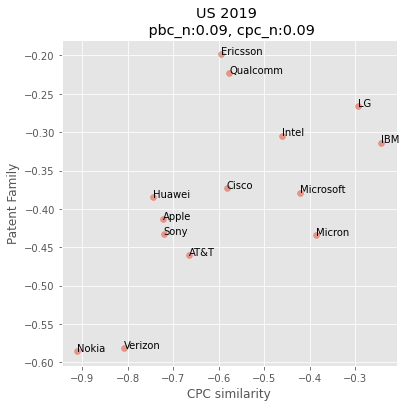

In [56]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("US 2019 \n pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC similarity")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [57]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [58]:
competitor_ls

[1, 1, 1, 2, 1, 2, 1, 4, 4, 3, 2, 4, 4, 4]

In [59]:
c_df

,cpc,country
company,,
Qualcomm,0.576785,0.222809
LG Electronics,0.294252,0.266057
IBM,0.242390,0.313657
Ericsson,0.595782,0.198698
Intel,0.461619,0.304417
Cisco Systems,0.582799,0.373297
Microsoft,0.420249,0.378882
Apple,0.722589,0.413501
AT&T,0.665305,0.459859


In [60]:
c_df.to_csv("competitor_df/company/cpc_us_2019.csv")

## DE

In [61]:
ccontry = pd.read_csv("../rm_company_country_de_2019.csv")
ccpc = pd.read_csv("../rm_company_cpc_de_2019.csv")

In [62]:
ccontry[ccontry.company.isin(com_de_ls)]

,company,AT,AU,CA,CH,CN,DE,EP,ES,FI,GB,JP,KR,RU,SG,TW,US
8,Bayerische Motoren Werke AG,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,Fraunhofer Gesellschaft zur Forderung der Ange...,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,Hyundai Motor Co,0.0,0.0,0.0,0.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0
61,Intel Corp,0.0,0.0,0.0,0.0,11.0,18.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,16.0
71,Kia Corp,0.0,0.0,0.0,0.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,12.0
76,LG Electronics Inc,0.0,0.0,0.0,0.0,11.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
85,NEC Corp,0.0,1.0,1.0,0.0,6.0,7.0,6.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,1.0
100,Robert Bosch GmbH,0.0,0.0,0.0,0.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
102,Samsung Electronics Co Ltd,0.0,3.0,1.0,0.0,16.0,18.0,3.0,0.0,0.0,0.0,1.0,16.0,0.0,5.0,8.0,18.0
107,Siemens AG,0.0,0.0,0.0,0.0,4.0,15.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Similarity計算

#### Country

- 換成機率  

In [63]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

#### PBC
- 和Samsung Electronics Co Ltd比較

In [64]:
ccontry_pbc = ccontry2.loc[com_de_ls,:].copy()
ccontry_pbc.head()

,AT,AU,CA,CH,CN,DE,EP,ES,FI,GB,JP,KR,RU,SG,TW,US
company,,,,,,,,,,,,,,,,
Intel Corp,0.0,0.000000,0.000000,0.0,0.234043,0.382979,0.000000,0.0,0.0,0.0,0.000000,0.042553,0.0,0.00000,0.000000,0.340426
Samsung Electronics Co Ltd,0.0,0.033708,0.011236,0.0,0.179775,0.202247,0.033708,0.0,0.0,0.0,0.011236,0.179775,0.0,0.05618,0.089888,0.202247
LG Electronics Inc,0.0,0.000000,0.000000,0.0,0.366667,0.366667,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.266667
Sony Corp,0.0,0.000000,0.000000,0.0,0.121212,0.303030,0.060606,0.0,0.0,0.0,0.151515,0.090909,0.0,0.00000,0.000000,0.272727
Siemens AG,0.0,0.000000,0.000000,0.0,0.148148,0.555556,0.296296,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.000000


In [65]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

#### CPC

In [66]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [67]:
ccpc_pbc = ccpc2.loc[com_de_ls,:].copy()
# ccpc_pbc

In [68]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### Scatter Plot

In [69]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_de_df.count_log[com_de_df.company=="Samsung Electronics Co Ltd"].values-com_de_df.count_log[com_de_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_de_df.count_log[com_de_df.company=="Samsung Electronics Co Ltd"].values-com_de_df.count_log[com_de_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

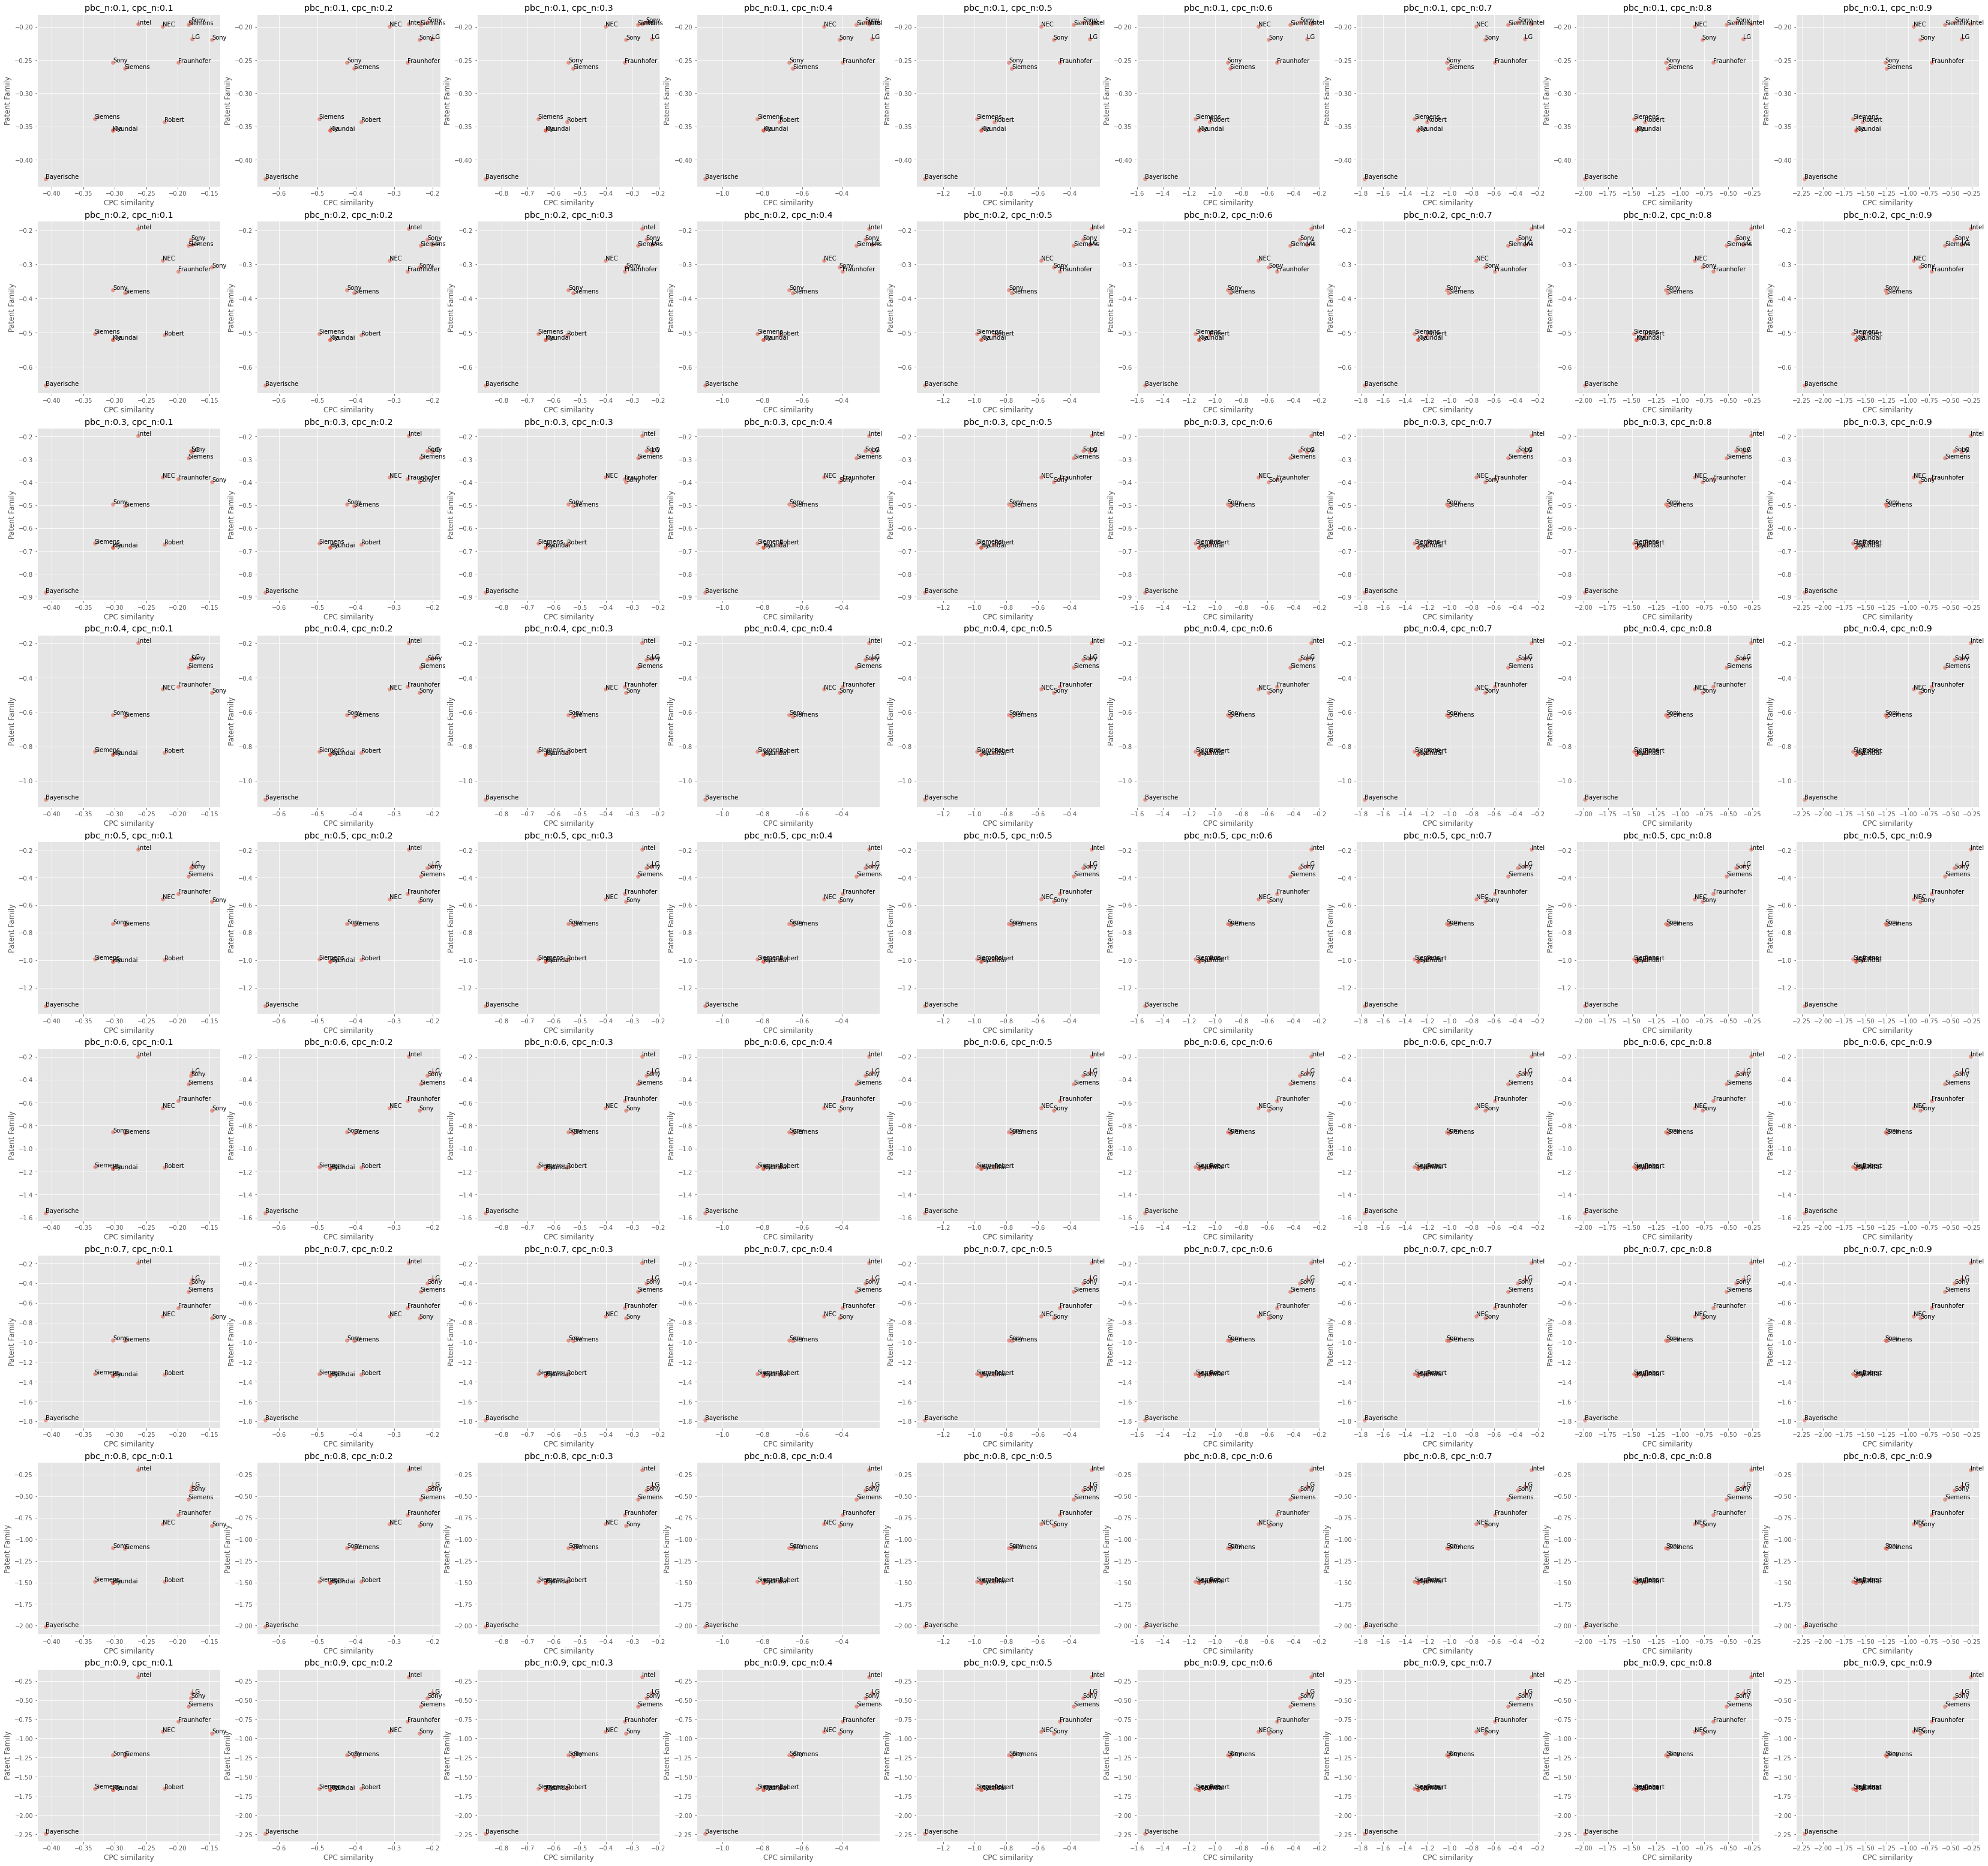

In [70]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_de_2019_1.png'.format(pbc_n))

In [71]:
c_df

,cpc,country
company,,
Intel Corp,0.263145,0.196032
LG Electronics Inc,0.371524,0.412287
Sony Corp,0.455356,0.469269
Siemens AG,0.567722,0.581388
Fraunhofer Gesellschaft zur Forderung der Angewandten Forschung eV,0.725232,0.780049
NEC Corp,0.937261,0.912842
Sony Group Corp,0.859278,0.932582
Sony Semiconductor Solutions Corp,1.268580,1.218945
Siemens Energy Global GmbH and Co KG,1.249857,1.228576


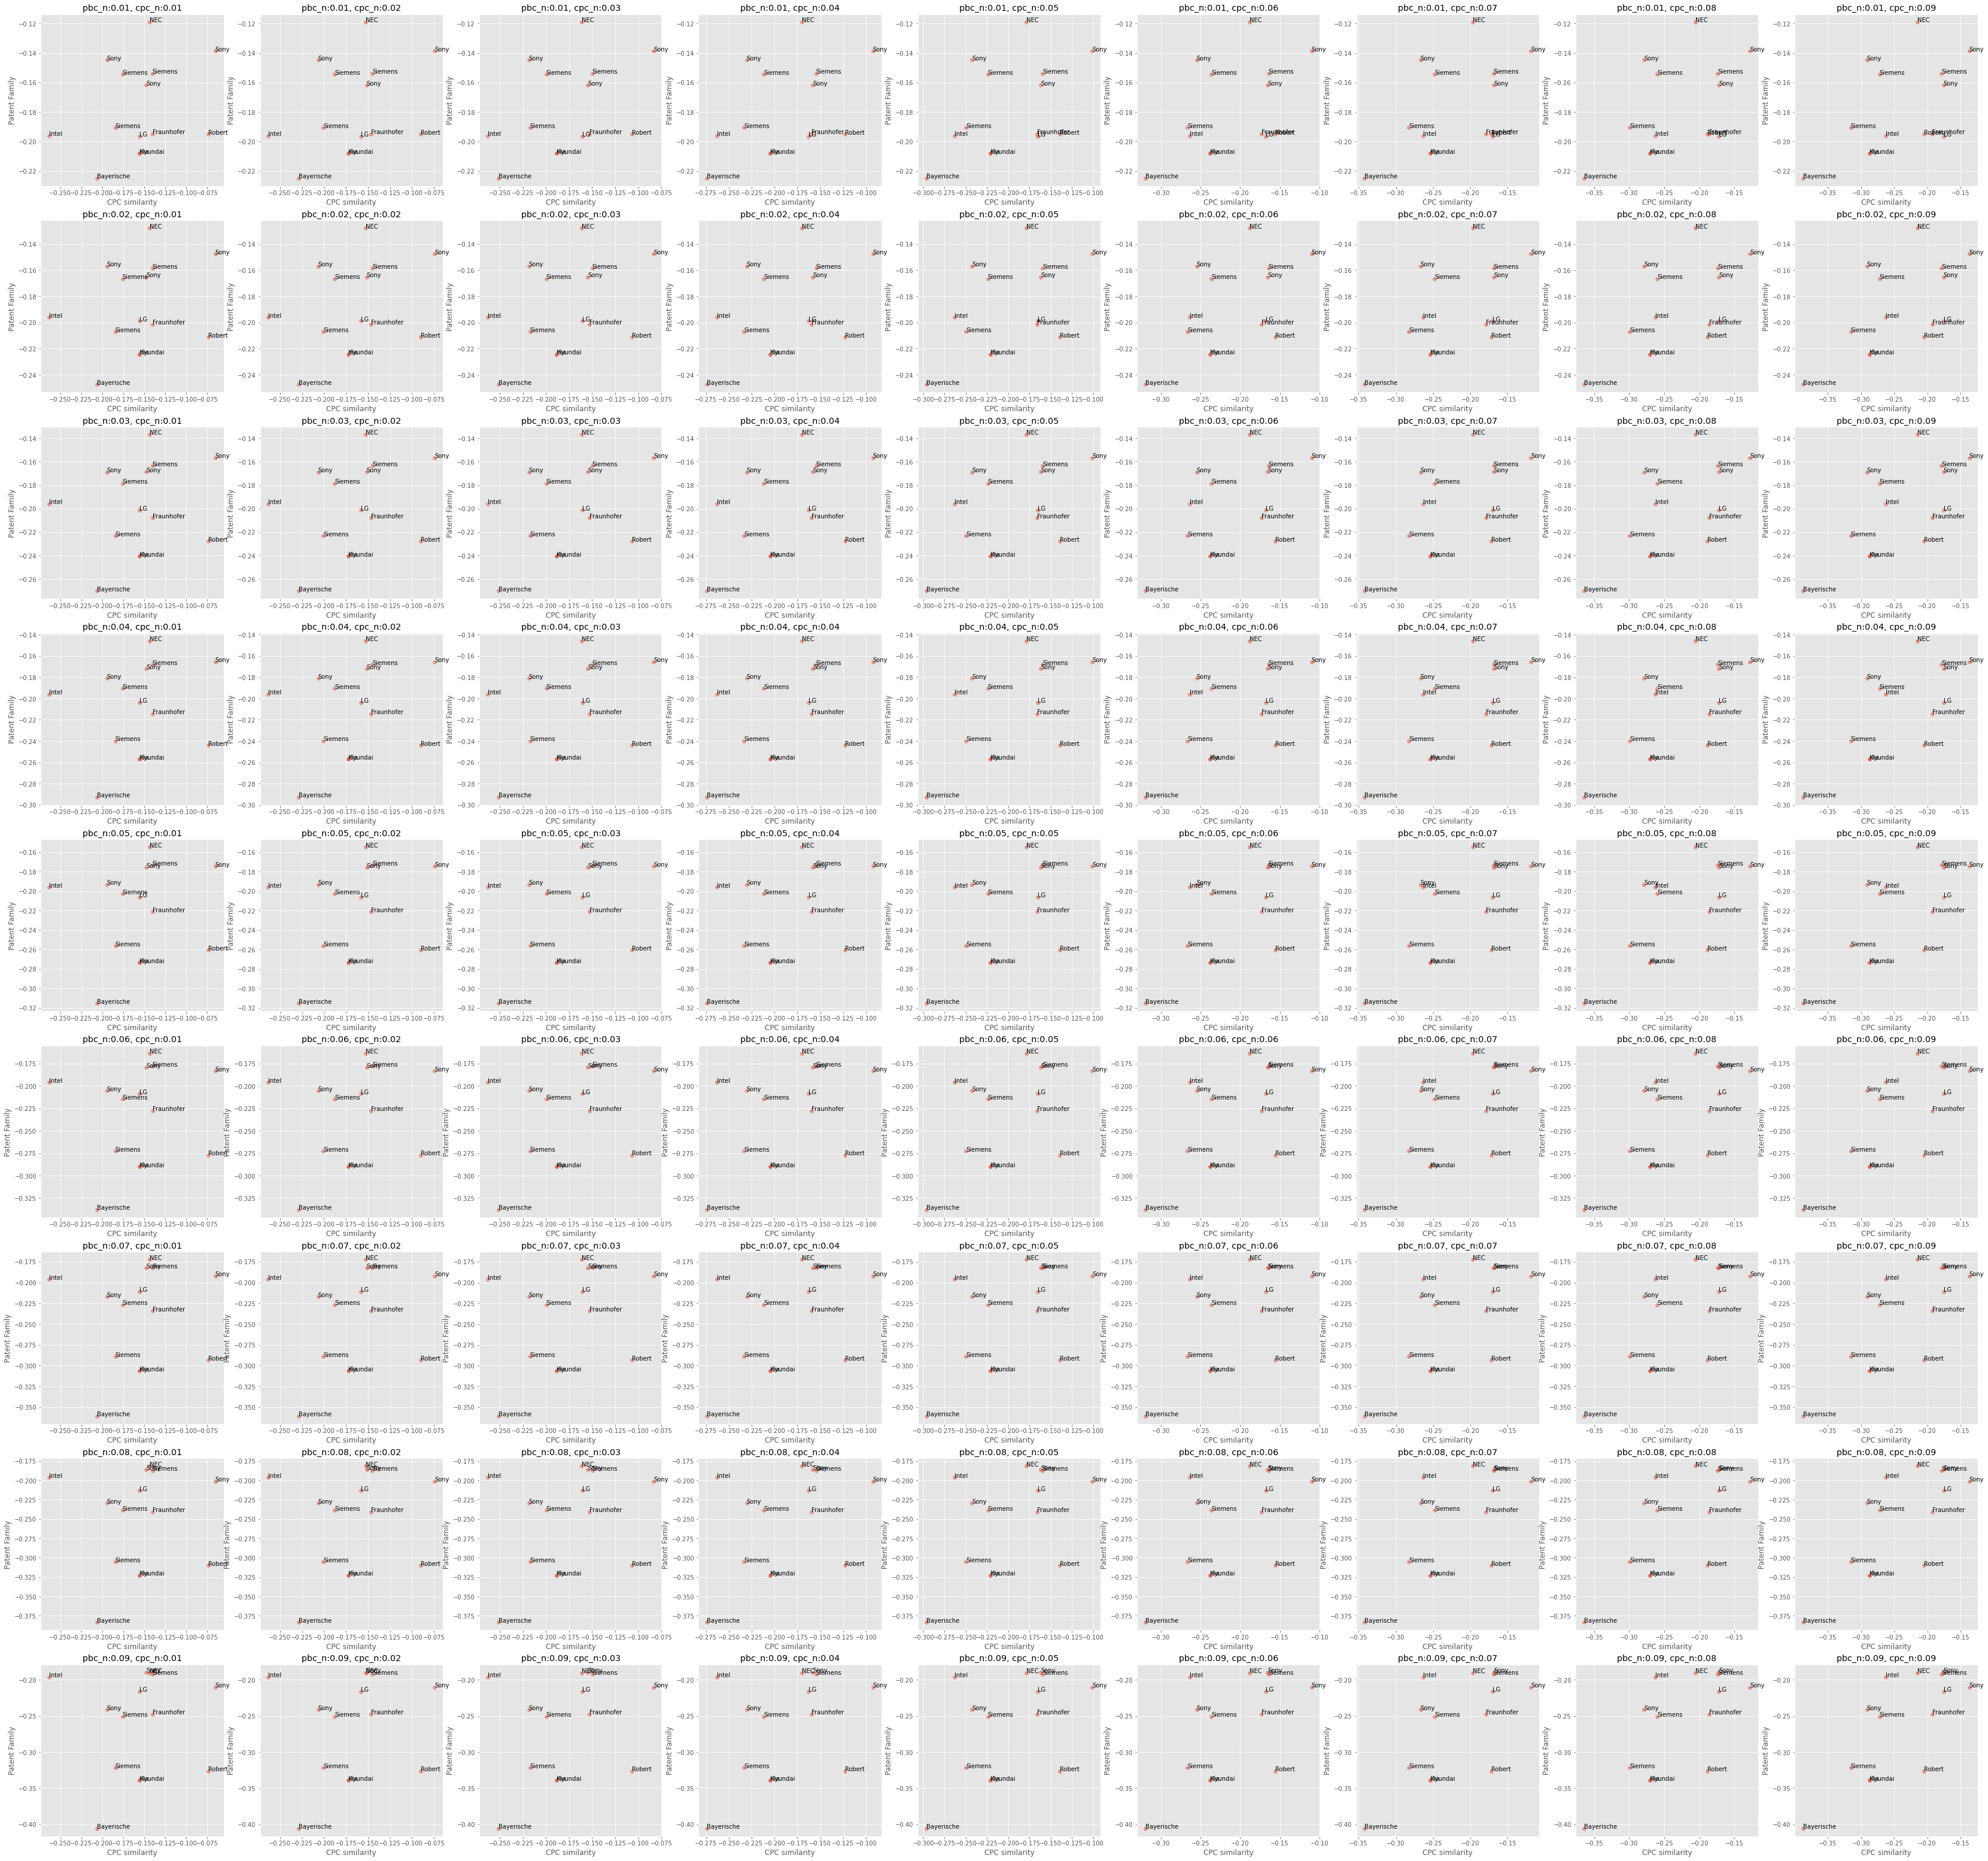

In [72]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC similarity")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_de_2019_2.png'.format(pbc_n))

In [73]:
c_df

,cpc,country
company,,
Intel Corp,0.263145,0.196032
LG Electronics Inc,0.175073,0.215835
Sony Corp,0.175506,0.189419
Siemens AG,0.178555,0.192221
Fraunhofer Gesellschaft zur Forderung der Angewandten Forschung eV,0.192570,0.247387
NEC Corp,0.214734,0.190316
Sony Group Corp,0.136751,0.210056
Sony Semiconductor Solutions Corp,0.290951,0.241317
Siemens Energy Global GmbH and Co KG,0.272228,0.250948


### Scatter Plot2

In [74]:
c_df = scatter_plot(pbc_n,cpc_n)
c_df = c_df.reset_index()
c_df["company"] = c_df.company.apply(lambda x: x.replace(" Inc","")\
                                                    .replace(" Co Ltd","")\
                                                    .replace(" Co. Ltd.","")\
                                                    .replace(" Co., Ltd.","")\
                                                    .replace(" Ltd","")\
                                                    .replace(" Corp","")\
                                                    .replace("..","")\
                                                    .replace("International Business Machines","IBM")\
                                                    .replace("Nippon Telegraph and Telephone","Nippon Telegraph & Tel")\
                                                    .replace("Alibaba Group Holding Ltd","Alibaba")\
                                                    .replace("ZTE Intelligent IoT Technology","ZTE")\
                                                    .replace("AT&T Intellectual Property I LP","AT&T")\
                                                    .replace("Microsoft Technology Licensing LLC","Microsoft")\
                                                    .replace("Telefonaktiebolaget LM Ericsson AB","Ericsson")\
                                                    .replace("Cisco Technology","Cisco Systems")\
                                                    .replace("Verizon Patent and Licensing","Verizon Communications")\
                                                    .replace("Nokia Technologies Oy","Nokia")\
                                                    .replace("China Mobile Communications Group","China Mobile")\
                                                    .replace("Nokia Solutions and Networks Oy","Nokia")\
                                                    .replace("China Mobile","China_Mobile")\
                                                    .replace("China Mobile IoT","China_Mobile_IoT")\
                                                    .replace("China United Network Communications Group","China_Unicom")\
                                                    .replace("Shanghai Langbo Communication Technology","Shanghai_Langbo")\
                                                    .replace("State Grid of China SGCC","SGCC")\
                                                    .replace("Beijing Sankuai Online Technology","Beijing_Sankuai")\
                                                    .replace("Beijing Xiaomi Mobile Software","Xiaomi")\
                                                    .replace("Guangdong Oppo Mobile Telecommunications","Oppo")\
                                                    .replace("Shanghai Roye Electric Science and Technology","Shanghai_Roye_Electric")\
                                                    .replace("Xian Irain IoT Technology Servic","Xian_Irain")\
                                                    .replace("China University of Geosciences","CUG")\
                                                    .replace("Shenzhen Shenglu IoT Communication Technology","Shenglu")\
                                                    .replace("Chengdu Qinchuan IoT Technology","Qinchuan_IoT")\
                                                    .replace("Hangzhou Wopu IoT Technology","Wopu_IoT")\
                                                    .replace("Huaway IoT Technology","Huaway_IoT")\
                                                    .replace("HUIZHOU TECHZEN IOT SCIENCE & TECHNOLOGY","HUIZHOU_TECHZEN_IOT")\
                                                    .replace("Anhui Sharetronic Iot Technology","Anhui_Sharetronic")\
                                                    .replace("Nanjing IoT Sensor Technology","Nanjing_IoT")\
                                                    .replace("SUZHOU XUANHE IOT TECHNOLOGY","SUZHOU_XUANHE_IOT")\
                                                    .replace("Jiangsu IoT Research and Development Center","Jiangsu_IoT")\
                                                    .replace("Shenzhen JBT Smart Lighting","JBT_Smart_Lighting")\
                                                    .replace("Shenzhen Mayixiongbing Iot Technology","Mayixiongbing_IoT")\
                                                    .replace("SHENZHEN QIANHAI LINGJU INTERNET OF THINGS SCIENCE & TECHNOLOGY","QIANHAI_LINGJU")\
                                                    .replace("Shenzhen Qianhai Livall IoT Technology","Livall")\
                                                    .replace("Nanjing Hansense Iot Technology","Hansense_IOT")\
                                                    .replace("GUANGDONG ABEJ IOT INTELLIGENT TECHNOLOGY","ABEJ_IOT")\
                                                    .replace("Tianjin Hui Zhiwulian Science And Technology","THZST")\
                                                    .replace("Chongqing Liuhe Iot","Chongqing_Liuhe_IOT")\
                                                    .replace("Huizhou Sanhe Iot Technology","Huizhou_Sanhe_IOT")\
                                                    .replace("T Mobile USA","T_Mobile_deA")\
                                                    .replace("Taiwan Semiconductor Manufacturing Co TSMC","TSMC")\
                                                    .replace("Suzhou Jiang Zuomen Network Technology","Suzhou_JZ")\
                                                    .replace("Suzhou Jiang Zuomen Network Tech","Suzhou_JZ_net")\
                                                    .replace("Sony Group","Sony_Group")\
                                                    .replace("Sony Semiconductor Solutions","Sony_Semiconductor")\
                                                    .replace("Siemens Energy Global GmbH and Co KG","Siemens_Energy")\
                                                    .replace("Siemens Mobility GmbH","Siemens_Mobility")\
                                                    .replace("Bayerische Motoren Werke AG","BMW")\
                                                    .replace("Friedrich Alexander Univeritaet Erlangen Nuernberg FAU","FAU")\
                                                    .replace("Intel IP","Intel_IP"))
c_df.set_index("company", inplace=True)
c_df = c_df.drop("Samsung Electronics")

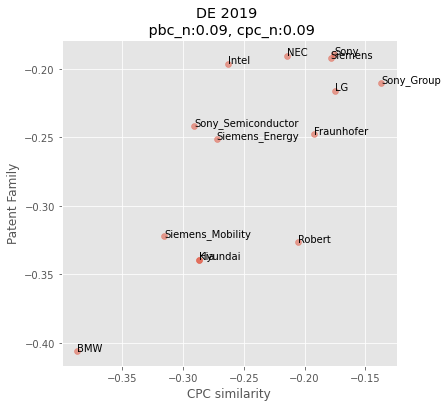

In [75]:
pbc_n=0.09
cpc_n=0.09
# c_df = scatter_plot(pbc_n,cpc_n)
# c_df = c_df.drop("Samsung Electronics Co Ltd")

plt.figure(figsize=(6,6))
plt.style.use('ggplot')
#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("DE 2019 \n pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC similarity")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [76]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [77]:
competitor_ls

[2, 1, 1, 1, 1, 1, 1, 2, 2, 4, 4, 4, 3, 4]

In [78]:
c_df

,cpc,country
company,,
Intel,0.263145,0.196032
LG Electronics,0.175073,0.215835
Sony,0.175506,0.189419
Siemens AG,0.178555,0.192221
Fraunhofer Gesellschaft zur Forderung der Angewandten Forschung eV,0.192570,0.247387
NEC,0.214734,0.190316
Sony_Group,0.136751,0.210056
Sony_Semiconductor,0.290951,0.241317
Siemens_Energy,0.272228,0.250948


In [79]:
c_df.to_csv("competitor_df/company/cpc_de_2019.csv")